In [ ]:
%pip install -r requirements.txt
#%pip uninstall -y tinarm
%pip install -e ../.


In [1]:
import pandas as pd
import pint_pandas
import logging
import tinarm
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
### Configure Logging
LOGGING_LEVEL = logging.INFO

logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-03-20 12:27:59,309 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - tinarm version 0.1
2024-03-20 12:27:59,310 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - pint_pandas version 0.5


In [3]:
# Get the operating points for the machine machine='M1'
# Each opperating point is a folder in the machine folder
machine = 'M1'
operating_points = [op_point for op_point in os.listdir(machine) if os.path.isdir(os.path.join(machine, op_point)) and not op_point.startswith('__pycache__')]

In [4]:
operating_points


['PeakTorqueBaseSpeed_36Nm_1380rpm',
 'Nominal_24Nm_2060rpm',
 'NominalPowerMaxSpeed_13Nm_3600rpm']

In [5]:
# check that we have all the expected charts
def check_charts(machine, operating_points):
    expected_charts = ['BackEmf.csv', 'CurrentAngle.csv',
                    'IronLoss.csv', 'MagnetLoss.csv',
                    'PhaseVoltage.csv', 'Torque.csv']
    for op_point in operating_points:
        print(f"Processing {op_point}")
        charts = [c for c in os.listdir(os.path.join(machine, op_point)) if c.endswith('.csv')]
        charts.sort()

        for chart in charts:
            if chart in expected_charts:
                # in green text
                print(f"\033[32m  {chart} found\033[0m")
            else:
                # in red text
                print(f"\033[31m  {chart} not found\033[0m")
        if "operating_point.py" in os.listdir(os.path.join(machine, op_point)):
            print(f"\033[32m  operating_point.py found\033[0m")
        else:
            print(f"\033[31m  operating_point.py not found\033[0m")
    return charts

charts = check_charts(machine, operating_points)



Processing PeakTorqueBaseSpeed_36Nm_1380rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py not found
Processing Nominal_24Nm_2060rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py found
Processing NominalPowerMaxSpeed_13Nm_3600rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py found


In [23]:
from M1 import machine as m
from M1.Nominal_24Nm_2060rpm import operating_point as nominal_op
from M1.NominalPowerMaxSpeed_13Nm_3600rpm import operating_point as max_speed_op

op_point = "Nominal_24Nm_2060rpm"
chart = "BackEmf.csv"
df = pd.read_csv(os.path.join(machine, op_point, chart), index_col=None, header=[0,1])

num_phases = m.winding_parameters["number_phases"].to_base_units().magnitude
num_pole_pairs = (m.rotor_parameters["number_poles"]//2).to_base_units().magnitude


In [7]:
def overlay_emf(df, num_phases, num_pole_pairs):
    assert num_phases == 3
    theta_m = np.hstack((np.deg2rad(df['EMFa']['X'] ),
            np.deg2rad((df['EMFb']['X']-(360/num_pole_pairs/num_phases))),
            np.deg2rad((df['EMFc']['X']+(360/num_pole_pairs/num_phases)))))


    v_emf = np.hstack((df['EMFa']['Y'],
                df['EMFb']['Y'],
                df['EMFc']['Y']))

    not_nan  = np.logical_not(np.logical_and(np.isnan(theta_m), np.isnan(v_emf)))
    theta_m = theta_m[not_nan]
    v_emf = v_emf[not_nan]
    sort_idx = np.argsort(theta_m)
    return theta_m[sort_idx], v_emf[sort_idx]

In [8]:
# set the initial guess, coef[0] is the phase offset, the rest are the cosine coefficients
coefs = np.array([np.nan,  np.nan, np.nan, np.nan,
       -9.96330324e-02, -1.11853145e+00, 2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02, 0, 0 ])
# make odd coefficients, from 1 to 2*len(coefs)-1
n_idx = np.arange(1, 2*len(coefs)-1, 2)

In [9]:
def predict(coefs, theta, num_pole_pairs=5):
    n_idx = np.arange(1, 2*len(coefs)-1, 2)
    pred = np.matmul(coefs[1:], np.cos(np.outer(n_idx, coefs[0] + theta * num_pole_pairs)))
    return pred

def loss(coefs, theta, v_emf):
    pred = predict(coefs, theta)
    return np.sum((v_emf - pred)**2)

In [12]:
#optimise the coefficients
theta_m, v_emf = overlay_emf(df, num_phases, num_pole_pairs)
peak_voltage = np.max(v_emf)
#set bounds that the coefficients must be positive
bounds = [(None, None) for _ in range(len(coefs))]
bounds[0] = (0, 2*np.pi/num_pole_pairs)
bounds[1] = (peak_voltage, peak_voltage * 1.5) # fundamental
bounds[2] = (-0.2 * peak_voltage , 0) # 3rd harmonic
bounds[3] = (-0.02 * peak_voltage , 0) # 5th harmonic
bounds[4] = (None , None) # 7th harmonic
bounds[5] = (None , None) # 9th harmonic
bounds[6] = (None , None) # (0.01 * peak_voltage , 0.2 * peak_voltage) # 11th harmonic

coefs[0:4] =np.mean(bounds[0:4], axis=1)
coefs

array([ 6.28318531e-01,  3.38499498e+02, -2.70799598e+01, -2.70799598e+00,
       -9.96330324e-02, -1.11853145e+00,  2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02,  0.00000000e+00,
        0.00000000e+00])

In [13]:
theta_m, v_emf = overlay_emf(df, num_phases, num_pole_pairs)
res = minimize(loss, coefs,
               args=(theta_m, v_emf),
               method='Nelder-Mead', tol=1e-6,
               bounds=bounds,
               options={'disp': True, "maxiter":9000})
print(res.success)

print(res.x)
back_emf_fit = {"phase_offset": -res.x[0], "coefs": res.x[1:]}

Optimization terminated successfully.
         Current function value: 602.757770
         Iterations: 4323
         Function evaluations: 5908
True
[ 2.17274092e-01  2.89932414e+02 -1.43344688e+01 -4.55514252e+00
 -5.04618632e-01 -4.98193418e-01  6.74392261e-01 -3.43212445e-01
  2.98385714e-01 -4.25465348e-02  6.80754358e-01 -3.79409793e-02
 -1.70002744e-02]


In [14]:
phase_emf_a = back_emf_fit["phase_offset"]/num_pole_pairs
phase_emf_b = back_emf_fit["phase_offset"]/num_pole_pairs +(2*np.pi / num_pole_pairs / num_phases)
phase_emf_c = back_emf_fit["phase_offset"]/num_pole_pairs +2*(2*np.pi / num_pole_pairs / num_phases)


In [15]:
from phase_a_emf import phase_a_emf
phase_a_emf(0)

array([270.01055664])

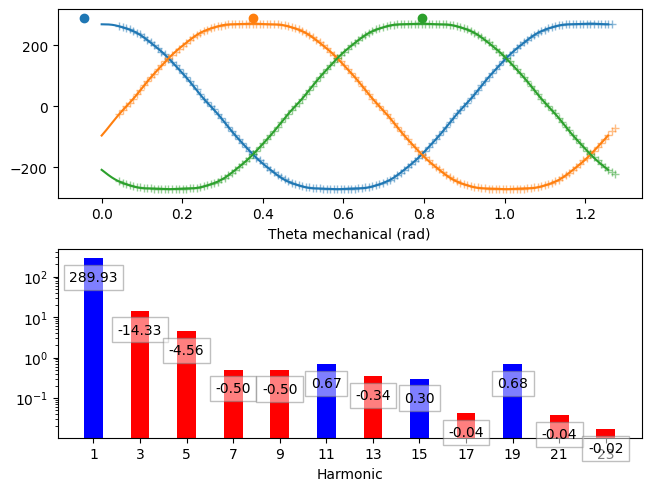

In [16]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
la, = ax_t.plot(np.deg2rad(df['EMFa']['X']), df['EMFa']['Y'], '+', alpha=0.5)
lb, = ax_t.plot(np.deg2rad(df['EMFb']['X']), df['EMFb']['Y'], '+', alpha=0.5)
lc, = ax_t.plot(np.deg2rad(df['EMFc']['X']), df['EMFc']['Y'], '+', alpha=0.5)

theta = np.linspace(0, 2*np.pi/num_pole_pairs, 1000)

ax_t.plot(theta, predict(res.x, theta), color=la.get_color())
ax_t.plot(theta, predict(res.x, theta-(2*np.pi/num_pole_pairs/num_phases)), color=lb.get_color())
ax_t.plot(theta, predict(res.x, theta+(2*np.pi/num_pole_pairs/num_phases)), color=lc.get_color())

ax_t.plot(phase_emf_a, res.x[1], 'o', color=la.get_color())
ax_t.plot(phase_emf_b, res.x[1], 'o', color=lb.get_color())
ax_t.plot(phase_emf_c, res.x[1], 'o', color=lc.get_color())
ax_t.set_xlabel('Theta mechanical (rad)')

ax_w.bar(n_idx, abs(res.x[1:]), color = ['r' if res.x[i] < 0 else 'b' for i in range(1, len(res.x))])
ax_w.set_xlabel('Harmonic')
ax_w.set_yscale('log')
ax_w.set_xticks(n_idx)
for i in range(1, len(res.x)):
    ax_w.text(n_idx[i-1], abs(res.x[i])*0.5, f"{res.x[i]:.2f}", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))

In [17]:
import yaml
from tinarm import Job
from tinarm import Machine
from tinarm.api import JOB_STATUS, STATUS_JOB
from tinarm import Api
import time

In [19]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm * 0.95}

In [20]:
with open("configurations.yaml", "r") as f:
    config = yaml.safe_load(f)

In [24]:
open_cct = nominal_op.operating_point.copy()
open_cct['current_density'] = 0.0 * q.A/q.mm**2
open_cct

{'current_density': 0.0 <Unit('ampere / millimeter ** 2')>,
 'current_angle': 255 <Unit('degree')>,
 'simulated_speed': 3600 <Unit('revolutions_per_minute')>}

In [25]:
api = Api(config["root_url"], config["api_key"], config["org_id"])
m1 = Machine(m.stator_parameters, m.rotor_parameters, m.winding_parameters)

j1 = Job(m1, open_cct, simulation_parameters, title="Open CCT")
j1_result = api.create_job(j1)
j1_result = api.update_job_status(j1.id, JOB_STATUS['QueuedForMeshing'])
init_time = time.time()
while STATUS_JOB[api.get_job(j1.id)['status']] != 'Complete':
    print("{2:2.4} {1} status {0}".format(STATUS_JOB[api.get_job(j1.id)['status']], j1.title, time.time()-init_time))
    time.sleep(10)
time.sleep(1)
print("{2:2.4}s {1} status {0}".format(STATUS_JOB[api.get_job(j1.id)['status']], j1.title, time.time()-init_time))

2024-03-20 12:31:05,847 - NoJobId - INFO - Martins-MacBook-Air.local - api.py->__init__() - root_url: https://api.build.tinarmengineering.com
2024-03-20 12:31:06,302 - NoJobId - INFO - Martins-MacBook-Air.local - api.py->update_job_status() - Updating job status: https://api.build.tinarmengineering.com/jobs/65fac8fac6470a0ba649d3a5/status/10?node_id=None&apikey=4c5d6be790cf69fd61c7d256ec6e0909&percentage_complete=None
0.5256 Open CCT status Solving
11.08 Open CCT status Solving
21.64 Open CCT status Solving
32.23 Open CCT status Solving
42.79 Open CCT status Solving
53.36 Open CCT status Solving
63.9 Open CCT status Solving
74.46 Open CCT status Solving
85.05 Open CCT status Solving
95.61 Open CCT status Solving
106.2 Open CCT status Solving
116.7 Open CCT status Solving
127.3 Open CCT status Solving
137.9 Open CCT status Solving
148.4 Open CCT status Solving
159.0 Open CCT status Solving
169.6 Open CCT status Solving
180.1 Open CCT status Solving
190.7 Open CCT status PostProcess
201.

In [26]:
j1_result = api.get_job(j1.id)
j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]

if j1_result_data['url'].startswith("http"):
    print("Result data available at", j1_result_data['url'])
    j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)
else:
    print("Result data not available yet. Have you promoted the artifact?")

Result data available at https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/jobs/65fac8fac6470a0ba649d3a5/postprocess/ScalarData.csv


In [27]:
j1_result_data['url']

'https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/jobs/65fac8fac6470a0ba649d3a5/postprocess/ScalarData.csv'

Error 545.4923354839959


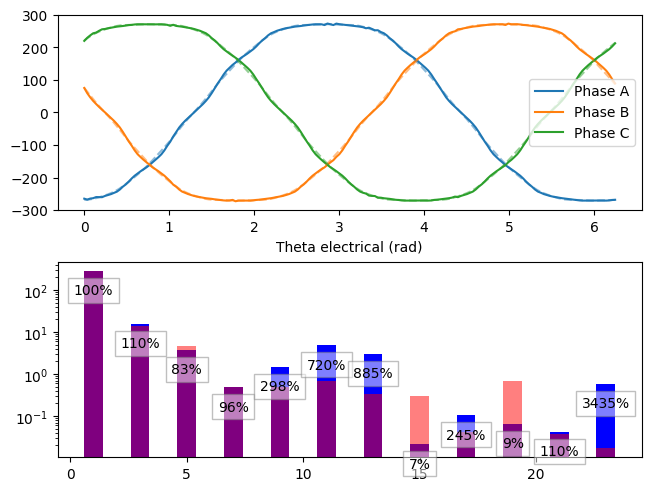

In [28]:
theta_err = np.pi+0.0129

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
la, = ax_t.plot(j1_df['angles'], j1_df['Back_EMF_0'], label='Phase A')
lb, = ax_t.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Phase B')
lc, = ax_t.plot(j1_df['angles'], j1_df['Back_EMF_2'], label='Phase C')

ax_t.plot(j1_df['angles'],
          predict(res.x, j1_df['angles']/num_pole_pairs+theta_err),
          '--',
          alpha=0.5,
          color=la.get_color())
ax_t.plot(j1_df['angles'],
          predict(res.x, j1_df['angles']/num_pole_pairs-(2*np.pi/num_pole_pairs/num_phases)+theta_err),
          '--', alpha=0.5,
          color=lb.get_color())
ax_t.plot(j1_df['angles'],
          predict(res.x, j1_df['angles']/num_pole_pairs+(2*np.pi/num_pole_pairs/num_phases)+theta_err),
          '--', alpha=0.5,
          color=lc.get_color())
ax_t.set_xlabel('Theta electrical (rad)')
ax_t.legend()
err = np.sum(np.abs(j1_df['Back_EMF_0'] - predict(res.x, j1_df['angles']/num_pole_pairs+theta_err)))
print(f"Error {err}")

# do an fft of the j1_df['Back_EMF_0'] and compare to the coefficients
from scipy.fft import fft
# Number of sample points
N = len(j1_df['Back_EMF_0'])
# sample spacing
delta_theta = np.diff(j1_df['angles'])[0]

yf = fft(j1_df['Back_EMF_0'].values, n=N)
ax_w.bar(x=range(1,24,2), height=np.abs(yf[1:24:2])/(N/2), color='b')
ax_w.bar(n_idx, abs(res.x[1:]), color = 'r', alpha=0.5)
ax_w.set_yscale('log')
for i in range(1, len(res.x)):
    diff = abs(yf[i*2-1]/(N/2)) / abs(res.x[i])
    ax_w.text(n_idx[i-1], abs(yf[i*2-1]/(N/2))*0.5, f"{diff:2.0%}", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))

In [29]:
current_df = pd.read_csv(os.path.join(machine, op_point, "CurrentAngle.csv"),
                         index_col=None, header=[0,1])
current_df

EMFb                Ib           
        X           Y     X          Y
0     2.5  -22.847020   2.5   9.093264
1     3.0  -12.294686   3.0   9.553712
2     3.5    0.388517   3.5  10.010397
3     4.0   11.791191   4.0  10.539684
4     4.5   23.269477   4.5  10.910622
..    ...         ...   ...        ...
137  71.0 -121.831940  71.0   5.249282
138  71.5 -108.902014  71.5   5.771912
139  72.0  -95.519828  72.0   6.392922
140  72.5  -81.846699  72.5   6.918868
141  73.0  -72.186883   NaN        NaN

[142 rows x 4 columns]

In [30]:
current_coef = np.array([1.5, 75]) #initial guess offset and amplitude
bounds = [(None, None) for _ in range(len(current_coef))]

def predict_current(coefs, theta, num_pole_pairs=5):
    pred = coefs[1] * np.cos(coefs[0] - (theta * num_pole_pairs))
    return pred

def loss_current(coefs, theta, current):
    current_b = predict_current(coefs, theta)
    return np.sum((current - current_b)**2)

res_current = minimize(loss_current, current_coef,
                       args=(np.deg2rad(current_df['Ib']['X']),
                             current_df['Ib']['Y']),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,)
print(res_current)

ib_mag = res_current.x[1]
phase_current_b = (res_current.x[0])/num_pole_pairs
print(phase_current_b)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.37156408149610504
             x: [ 1.128e+00  1.475e+01]
           nit: 70
          nfev: 133
 final_simplex: (array([[ 1.128e+00,  1.475e+01],
                       [ 1.128e+00,  1.475e+01],
                       [ 1.128e+00,  1.475e+01]]), array([ 3.716e-01,  3.716e-01,  3.716e-01]))
0.225644798892389


Phase difference -42.908638326034584 degrees


Text(0.5, 0, 'Theta electrical (deg)')

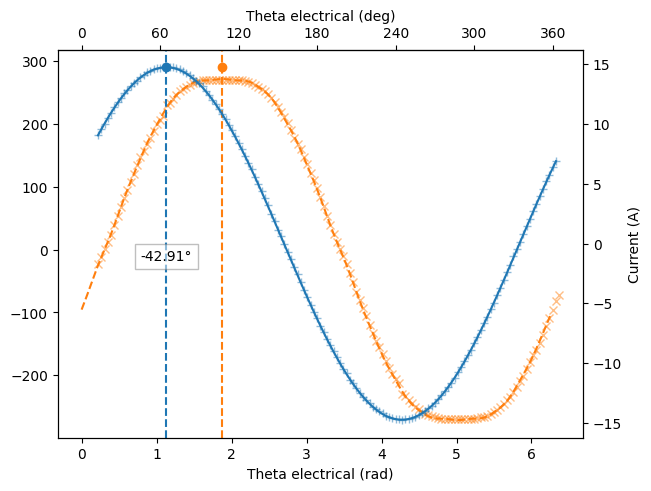

In [40]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
l_emf_b, = ax_t.plot(np.deg2rad(current_df['EMFb']['X'])*num_pole_pairs,
          current_df['EMFb']['Y'], 'x', alpha=0.5, color=lb.get_color())

ax_right = ax_t.twinx()
l_ib, =  ax_right.plot(np.deg2rad(current_df['Ib']['X'])*num_pole_pairs,
          current_df['Ib']['Y'], '+', alpha=0.5)

ax_t.plot(j1_df['angles'],
          predict(res.x, j1_df['angles']/num_pole_pairs-(2*np.pi/num_pole_pairs/num_phases)),
          '--',
          color=lb.get_color())

ax_right.plot(np.deg2rad(current_df['Ib']['X'])*num_pole_pairs,
          predict_current(res_current.x, np.deg2rad(current_df['Ib']['X'])),
          color=l_ib.get_color())
ax_right.set_ylabel('Current (A)')

ax_right.plot(phase_current_b*num_pole_pairs, ib_mag, 'o', color=l_ib.get_color())
ax_t.plot(phase_emf_b*num_pole_pairs, res.x[1], 'o', color=lb.get_color())
ax_t.axvline(phase_emf_b*num_pole_pairs, color=lb.get_color(), linestyle='--')
ax_t.axvline(phase_current_b*num_pole_pairs, color=l_ib.get_color(), linestyle='--')
phase_difference = np.rad2deg((phase_current_b - phase_emf_b)*num_pole_pairs)
print(f"Phase difference {phase_difference} degrees")
ax_t.text(phase_current_b * num_pole_pairs, 0, f"{phase_difference:.2f}°", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))   
ax_t.set_xlabel('Theta electrical (rad)')
#set markers in degrees on the top axis
# add a x-axis spine on top
ax_ttop = ax_t.secondary_xaxis('top')
ax_ttop.set_xlabel('Theta electrical (rad)')
tick_pos = [0, 60, 120, 180, 240, 300, 360]
ax_ttop.set_xticks(np.deg2rad(tick_pos))
ax_ttop.set_xticklabels(tick_pos)
ax_ttop.set_xlabel('Theta electrical (deg)')

In [ ]:
torque_df = pd.read_csv(os.path.join(machine, op_point, 'Torque.csv'),
                         index_col=None, header=[0,1])
torque_df

In [ ]:
arg_idx = np.argsort(np.deg2rad(torque_df['Torque']['X'])%(np.pi/5/3))

In [ ]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3),
          torque_df['Torque']['Y'][arg_idx], 'g-x', alpha=0.5)

In [ ]:
def torque_predict(coefs, theta, harm=[6, 12, 24, 30, 33, 36, 40, 43, 46], num_pole_pairs=5):
    pred = coefs[0] + np.matmul(coefs[2:], np.cos(np.outer(harm, (coefs[1]+theta))))
    return pred
def torque_loss(coefs, theta, torque):
    pred = torque_predict(coefs, theta)
    return np.sum((torque - pred)**2)


In [ ]:
torque_coefs = np.array([30, 0, 1,0,0, 0,0,0, 0,0,1])
test = torque_predict(torque_coefs, np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3))
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), test, 'r-')

In [ ]:

torque_coefs = np.array([30, 0, 1, -1, 1, 0, 0])
bounds = [(None, None) for _ in range(len(torque_coefs))]
bounds[0] = (28, 32)
res_torque = minimize(torque_loss, torque_coefs, args=(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3),
                             torque_df['Torque']['Y'][arg_idx]),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,
                             options={'disp': True, "maxiter":9000})
print(res_torque)

In [ ]:
test = torque_predict(res_torque.x, np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3))
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), test, 'r-')
plt.plot(np.deg2rad(torque_df['Torque']['X'][arg_idx])%(np.pi/5/3), torque_df['Torque']['Y'][arg_idx], 'g-x', alpha=0.5)

In [ ]:
#do a fft on the torque
from scipy.fft import fft
torque_fft = fft(torque_df['Torque']['Y'].values, n=torque_df['Torque']['Y'].size, )
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
ax_t.plot(np.abs(torque_fft[0:int(torque_df['Torque']['Y'].size/2)]), 'g-x', alpha=0.5)
ax_t.set_yscale('log')

In [ ]:
#detect the peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(np.abs(torque_fft[0:int(torque_df['Torque']['Y'].size/2)]), height=0.1)
peaks

In [ ]:
#make a copy of the fft with only the peaks
torque_fft_peaks = np.zeros_like(torque_fft)
torque_fft_peaks[peaks] = torque_fft[peaks]

In [ ]:
# produce a waveform from the ifft of the peaks and the phase

from scipy.fft import ifft
torque_waveform = ifft(torque_fft_peaks)
plt.plot(abs(torque_waveform))

In [ ]:
abs(ifft(torque_fft))